### Generative Adversarial Networks  
Jay Urbain, Phd

Credits:  
- https://github.com/eriklindernoren/Keras-GAN  
- The network architecture has been found by, and optimized by, many contributors, including the authors of the DCGAN paper and people like Erik Linder-Norén, who’s excellent collection of GAN implementations called Keras GAN served as the basis of the code used here.

In [24]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
print('Ok')

# K.set_image_dim_ordering('tf')

#np.random.seed(1337)

Ok


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [25]:
!ls '/content/gdrive/My Drive/Colab Notebooks'

'convnets-with-small-datasets (1).ipynb'   dcgan_mnist_images
'convnets-with-small-datasets (2).ipynb'   generative_adversarial_network.ipynb
'convnets-with-small-datasets (3).ipynb'   Untitled0.ipynb
 convnets-with-small-datasets.ipynb	   Untitled1.ipynb
'Copy of Drive FUSE example.ipynb'	   Untitled2.ipynb
'Copy of EnsDeepCNNs_ChestXrays.ipynb'	   Untitled3.ipynb
 dcgan.ipynb				   using-a-pretrained-convnet.ipynb


In [0]:
#!mkdir '/content/gdrive/My Drive/Colab Notebooks/dcgan_mnist_images'

In [0]:
dcgan_mnist_images = '/content/gdrive/My Drive/Colab Notebooks/dcgan_mnist_images'

The MNIST dataset consists of 60,000 hand-drawn numbers, 0 to 9. Keras provides us with a built-in loader that splits it into 50,000 training images and 10,000 test images. We will use the following code to load the dataset:

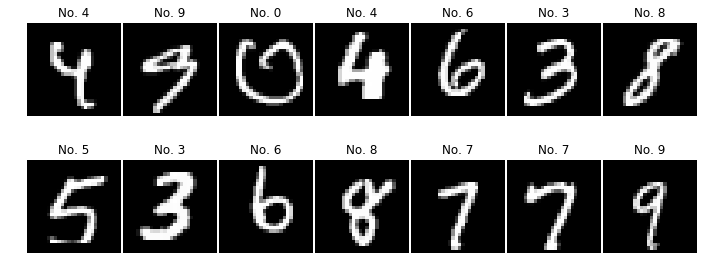

In [28]:
from keras.datasets.mnist import load_data

# load the data - it returns 2 tuples of digits & labels - one for
# the train set & the other for the test set
(train_digits, train_labels), (test_digits, test_labels) = mnist.load_data()

# display 14 random images from the training set
import numpy as np
np.random.seed(123)

rand_14 = np.random.randint(0, train_digits.shape[0],14)
sample_digits = train_digits[rand_14]
sample_labels = train_labels[rand_14]
# code to view the images
num_rows, num_cols = 2, 7
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),
                     gridspec_kw={'wspace':0.03, 'hspace':0.01}, 
                     squeeze=True)

for r in range(num_rows):
    for c in range(num_cols):
        image_index = r * 7 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_digits[image_index], cmap='gray')
        ax[r,c].set_title('No. %d' % sample_labels[image_index])
plt.show()
plt.close()

In [0]:
def load_data():
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [30]:
X_train = load_data()

num_examples = np.shape(X_train)
print('Number of examples: ', num_examples)
#print('Shape: ', np.shape(X_train))

Number of examples:  (60000, 28, 28, 1)


In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model



In [0]:
def train(generator, discriminator, combined, epochs=2000, batch_size=128, save_interval=50):

    X_train = load_data()

    num_examples = X_train.shape[0]
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise = np.random.normal(0, 1, (half_batch, 100))
            fake_images = generator.predict(noise)
            fake_labels = np.zeros((half_batch, 1))

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 50 == 0:
                save_imgs(generator, epoch, batch)


In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(dcgan_mnist_images + "/mnist_%d_%d.png" % (epoch, batch))
    plt.close()


In [0]:
def build_models():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])

    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

    z = Input(shape=(100,))
    img = generator(z)
    discriminator.trainable = False
    real = discriminator(img)
    combined = Model(z, real)
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined

In [0]:
def main():
    generator, discriminator, combined = build_models()

    train(generator, discriminator, combined,
          epochs=100, batch_size=32, save_interval=1)

In [0]:
main()

-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)          

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/1875 [D loss: 1.059742, acc.: 37.50%] [G loss: 0.471491]
Epoch 0 Batch 1/1875 [D loss: 0.730740, acc.: 59.38%] [G loss: 0.625148]
Epoch 0 Batch 2/1875 [D loss: 0.586465, acc.: 65.62%] [G loss: 0.641022]
Epoch 0 Batch 3/1875 [D loss: 0.433604, acc.: 84.38%] [G loss: 0.861166]
Epoch 0 Batch 4/1875 [D loss: 0.432078, acc.: 78.12%] [G loss: 1.068855]
Epoch 0 Batch 5/1875 [D loss: 0.347893, acc.: 87.50%] [G loss: 1.202768]
Epoch 0 Batch 6/1875 [D loss: 0.391010, acc.: 75.00%] [G loss: 1.124671]
Epoch 0 Batch 7/1875 [D loss: 0.381522, acc.: 87.50%] [G loss: 1.529527]
Epoch 0 Batch 8/1875 [D loss: 0.337792, acc.: 90.62%] [G loss: 1.586120]
Epoch 0 Batch 9/1875 [D loss: 0.320523, acc.: 84.38%] [G loss: 1.469469]
Epoch 0 Batch 10/1875 [D loss: 0.282992, acc.: 93.75%] [G loss: 1.615393]
Epoch 0 Batch 11/1875 [D loss: 0.315055, acc.: 93.75%] [G loss: 1.633769]
Epoch 0 Batch 12/1875 [D loss: 0.332357, acc.: 90.62%] [G loss: 1.520791]
Epoch 0 Batch 13/1875 [D loss: 0.243631, acc.: 9